**Hollweg Dispersion Solver**

This python notebook details the functionality of the hollweg() function. This function computes the wave frequencies for given wavenumbers and plasma parameters based on the solution to the two fluid dispersion relation presented by Hollweg 1999, and further summarized by Bellan 2012. In his derivation Hollweg assumed a uniform magnetic field, zero D.C electric field, quasi-neutrality, and low-frequency waves

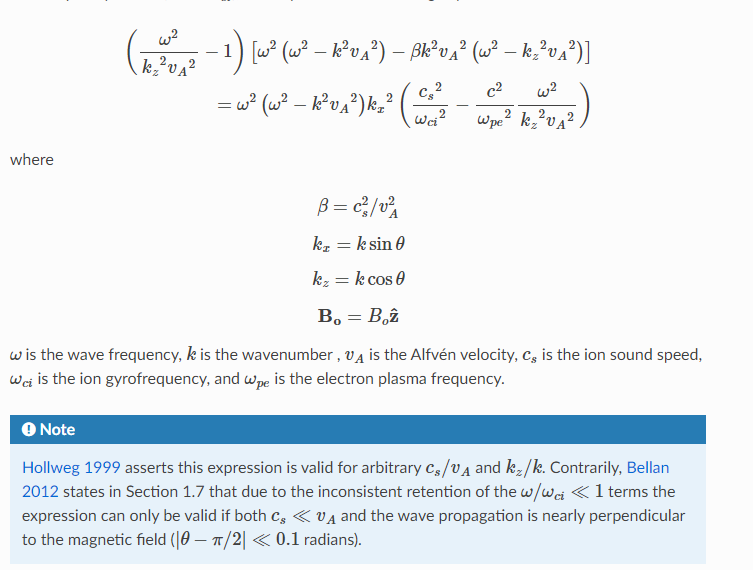

**Contents:**

1. Wave propagating at nearly 90 degrees

2. Hollweg 1999 and Bellan 2012 comparison

3. Reproduce Figure 2 from Hollweg 1999

In [ ]:
pip install plasmapy

In [5]:
import plasmapy

In [6]:
import plasmapy.dispersion.dispersionfunction

In [ ]:
help(plasmapy.dispersion.dispersionfunction.plasma_dispersion_func)

In [2]:
%matplotlib inline

import astropy.units as u
import matplotlib.pyplot as plt
import numpy as np
import warnings

from astropy.constants.si import c
from matplotlib.ticker import MultipleLocator

In [8]:
import plasmapy.dispersion.dispersionfunction

In [9]:


from plasmapy.dispersion.analytical.two_fluid_ import two_fluid
from plasmapy.dispersion.numerical.hollweg_ import hollweg
from plasmapy.formulary import (
    Alfven_speed,
    gyrofrequency,
    inertial_length,
    ion_sound_speed,
    plasma_frequency,
)
from plasmapy.particles import Particle
from plasmapy.utils.exceptions import PhysicsWarning

warnings.filterwarnings(
    action="ignore",
    category=PhysicsWarning,
    module="plasmapy.dispersion.numerical.hollweg_",
)

plt.rcParams["figure.figsize"] = [10.5, 0.56 * 10.5]

**Wave propagating at nearly 90 degrees**

Below we define the required parameters to compute the wave frequencies.

In [11]:
# define input parameters
inputs = {
    "k": np.logspace(-7, -2, 300) * u.rad / u.m,
    "theta": 89 * u.deg,
    "n_i": 5 * u.cm**-3,
    "B": 1.10232e-8 * u.T,
    "T_e": 1.6e6 * u.K,
    "T_i": 4.0e5 * u.K,
    "ion": Particle("p+"),
}

In [12]:
# a few useful plasma parameters
params = {
    "n_e": inputs["n_i"] * abs(inputs["ion"].charge_number),
    "cs": ion_sound_speed(
        inputs["T_e"],
        inputs["T_i"],
        inputs["ion"],
    ),
    "va": Alfven_speed(
        inputs["B"],
        inputs["n_i"],
        ion=inputs["ion"],
    ),
    "wci": gyrofrequency(inputs["B"], inputs["ion"]),
}

In [13]:
params["lpe"] = inertial_length(params["n_e"], "e-")
params["wpe"] = plasma_frequency(params["n_e"], "e-")

# compute
omegas1 = hollweg(**inputs)
omegas2 = two_fluid(**inputs)
np.set_printoptions(precision=4, threshold=20)

The computed wave frequencies (rad/s) are returned in a dictionary with the keys representing wave modes and the values (instances of Astropy Quantity) being the frequencies. Since our inputs were a 1D arrays of of
’s, the computed wave frequencies will be a 1D array of size equal to the size of the K array.

In [14]:
(list(omegas1.keys()), omegas1["fast_mode"], omegas1["fast_mode"].shape)

(['fast_mode', 'alfven_mode', 'acoustic_mode'],
 <Quantity [1.8619e-02+0.j, 1.9350e-02+0.j, 2.0109e-02+0.j, ...,
            1.0663e+03+0.j, 1.1072e+03+0.j, 1.1498e+03+0.j] rad / s>,
 (300,))

Let’s plot the results of each wave mode.

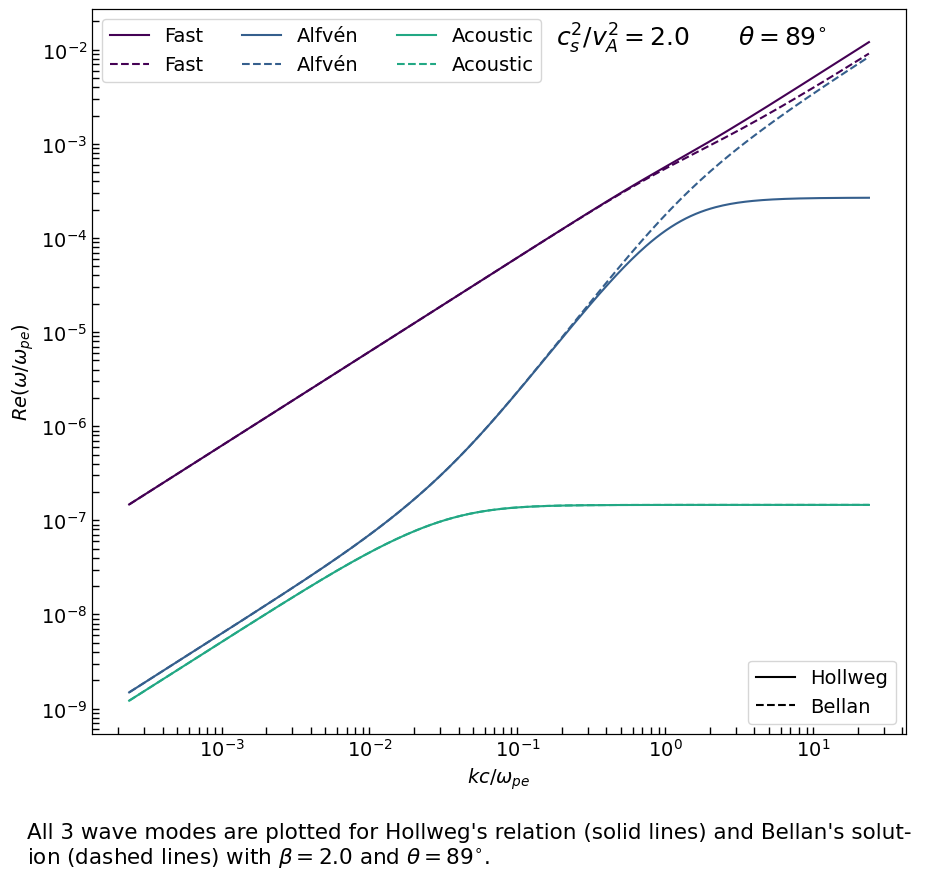

In [15]:
fs = 14  # default font size
figwidth, figheight = plt.rcParams["figure.figsize"]
figheight = 1.6 * figheight
fig = plt.figure(figsize=[figwidth, figheight])

# normalize data
k_prime = inputs["k"] * params["lpe"]

# define colormap
cmap = plt.get_cmap("viridis")
slicedCM = cmap(np.linspace(0, 0.6, 3))

# plot
(p1,) = plt.plot(
    k_prime,
    np.real(omegas1["fast_mode"] / params["wpe"]),
    "--",
    c=slicedCM[0],
    ms=1,
    label="Fast",
)
ax = plt.gca()
(p2,) = ax.plot(
    k_prime,
    np.real(omegas1["alfven_mode"] / params["wpe"]),
    "--",
    c=slicedCM[1],
    ms=1,
    label="Alfvén",
)
(p3,) = ax.plot(
    k_prime,
    np.real(omegas1["acoustic_mode"] / params["wpe"]),
    "--",
    c=slicedCM[2],
    ms=1,
    label="Acoustic",
)
(p4,) = plt.plot(
    k_prime,
    np.real(omegas2["fast_mode"] / params["wpe"]),
    c=slicedCM[0],
    ms=1,
    label="Fast",
)
ax = plt.gca()
(p5,) = ax.plot(
    k_prime,
    np.real(omegas2["alfven_mode"] / params["wpe"]),
    c=slicedCM[1],
    ms=1,
    label="Alfvén",
)
(p6,) = ax.plot(
    k_prime,
    np.real(omegas2["acoustic_mode"] / params["wpe"]),
    c=slicedCM[2],
    ms=1,
    label="Acoustic",
)

# adjust axes
ax.set_xlabel(r"$kc / \omega_{pe}$", fontsize=fs)
ax.set_ylabel(r"$Re(\omega / \omega_{pe})$", fontsize=fs)
ax.set_yscale("log")
ax.set_xscale("log")
ax.tick_params(
    which="both",
    direction="in",
    width=1,
    labelsize=fs,
    right=True,
    length=5,
)

# annotate
styles = ["-", "--"]
s_labels = ["Hollweg", "Bellan"]
ax2 = ax.twinx()
for ss, lab in enumerate(styles):
    ax2.plot(np.NaN, np.NaN, ls=styles[ss], label=s_labels[ss], c="black")
ax2.get_yaxis().set_visible(False)
ax2.legend(fontsize=14, loc="lower right")

text1 = (
    f"$c_s^2/v_A^2 = {params['cs'] ** 2 / params['va'] ** 2:.1f} \qquad "
    f"\\theta = {inputs['theta'].value:.0f}"
    "^{\\circ}$"
)
text2 = (
    "All 3 wave modes are plotted for Hollweg's relation (solid lines) and Bellan's solut- \n"
    f"ion (dashed lines) with $\\beta = 2.0$ and $\\theta = {inputs['theta'].value:.0f}"
    "^{\\circ}$."
)
plt.figtext(-0.08, -0.18, text2, ha="left", transform=ax.transAxes, fontsize=15.5)
ax.text(0.57, 0.95, text1, transform=ax.transAxes, fontsize=18)
ax.legend(handles=[p4, p1, p5, p2, p6, p3], fontsize=14, ncol=3, loc="upper left")

**Hollweg 1999 and Bellan 2012 comparison**

 Bellan 2012 chooses parameters such that image.png and Below we define parameters to approximate Bellan’s assumptions.

In [16]:
# define input parameters
inputs = {
    "B": 400e-4 * u.T,
    "ion": Particle("He+"),
    "n_i": 6.358e19 * u.m**-3,
    "T_e": 20 * u.eV,
    "T_i": 10 * u.eV,
    "theta": np.linspace(0, 90) * u.deg,
    "k": (2 * np.pi * u.rad) / (0.56547 * u.m),
}

# a few useful plasma parameters
params = {
    "n_e": inputs["n_i"] * abs(inputs["ion"].charge_number),
    "cs": ion_sound_speed(inputs["T_e"], inputs["T_i"], inputs["ion"]),
    "wci": gyrofrequency(inputs["B"], inputs["ion"]),
    "va": Alfven_speed(inputs["B"], inputs["n_i"], ion=inputs["ion"]),
}
params["beta"] = (params["cs"] / params["va"]).value ** 2
params["wpe"] = plasma_frequency(params["n_e"], "e-")
params["Lambda"] = (inputs["k"] * params["va"] / params["wci"]).value ** 2

(params["beta"], params["Lambda"])

(0.4000832135717194, 0.4000017351804854)

we can see here image.png Hollweg 1999 (0.4000832135717194, 0.4000017351804854)

In [17]:
# compute omegas for Bellan and Hollweg
bellan_omegas = two_fluid(**inputs)
hollweg_omegas = hollweg(**inputs)

In [20]:
# generate data for Bellan curves
bellan_plt_vals = {}
for mode, arr in bellan_omegas.items():
    norm = (np.absolute(arr) / (inputs["k"] * params["va"])).value ** 2
    bellan_plt_vals[mode] = {
        "x": norm * np.sin(inputs["theta"].to(u.rad).value),
        "y": norm * np.cos(inputs["theta"].to(u.rad).value),
    }


In [22]:
# generate data for Hollweg curves
hollweg_plt_vals = {}
for mode, arr in hollweg_omegas.items():
    norm = (np.absolute(arr) / (inputs["k"] * params["va"])).value ** 2
    hollweg_plt_vals[mode] = {
        "x": norm * np.sin(inputs["theta"].to(u.rad).value),
        "y": norm * np.cos(inputs["theta"].to(u.rad).value),
    }

Let’s plot all 3 wave modes

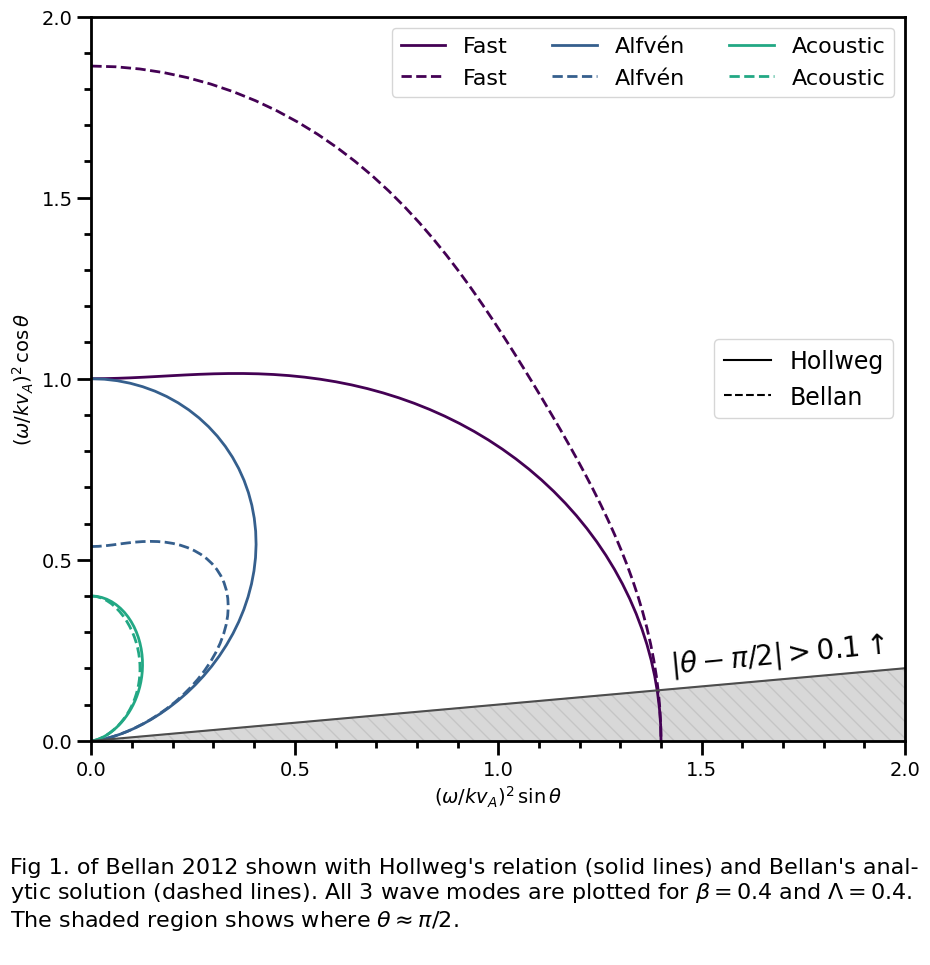

In [23]:
fs = 14  # default font size
figwidth, figheight = plt.rcParams["figure.figsize"]
figheight = 1.6 * figheight
fig = plt.figure(figsize=[figwidth, figheight])

# define colormap
cmap = plt.get_cmap("viridis")
slicedCM = cmap(np.linspace(0, 0.6, 3))

# Bellan Fast mode
(p1,) = plt.plot(
    bellan_plt_vals["fast_mode"]["x"],
    bellan_plt_vals["fast_mode"]["y"],
    "--",
    c=slicedCM[0],
    linewidth=2,
    label="Fast",
)
ax = plt.gca()

# adjust axes
ax.set_xlabel(r"$(\omega / k v_{A})^{2} \, \sin \theta$", fontsize=fs)
ax.set_ylabel(r"$(\omega / k v_{A})^{2} \, \cos \theta$", fontsize=fs)
ax.set_xlim(0.0, 2.0)
ax.set_ylim(0.0, 2.0)
for spine in ax.spines.values():
    spine.set_linewidth(2)
ax.minorticks_on()
ax.tick_params(which="both", labelsize=fs, width=2)
ax.tick_params(which="major", length=10)
ax.tick_params(which="minor", length=5)
ax.xaxis.set_major_locator(MultipleLocator(0.5))
ax.xaxis.set_minor_locator(MultipleLocator(0.1))
ax.yaxis.set_major_locator(MultipleLocator(0.5))
ax.yaxis.set_minor_locator(MultipleLocator(0.1))

# Bellan Alfven mode
(p2,) = plt.plot(
    bellan_plt_vals["alfven_mode"]["x"],
    bellan_plt_vals["alfven_mode"]["y"],
    "--",
    c=slicedCM[1],
    linewidth=2,
    label="Alfvén",
)

# Bellan Acoustic mode
(p3,) = plt.plot(
    bellan_plt_vals["acoustic_mode"]["x"],
    bellan_plt_vals["acoustic_mode"]["y"],
    "--",
    c=slicedCM[2],
    linewidth=2,
    label="Acoustic",
)

# Hollweg Fast mode
(p4,) = plt.plot(
    hollweg_plt_vals["fast_mode"]["x"],
    hollweg_plt_vals["fast_mode"]["y"],
    c=slicedCM[0],
    linewidth=2,
    label="Fast",
)

# Hollweg Alfven mode
(p5,) = plt.plot(
    hollweg_plt_vals["alfven_mode"]["x"],
    hollweg_plt_vals["alfven_mode"]["y"],
    c=slicedCM[1],
    linewidth=2,
    label="Alfvén",
)

# Hollweg Acoustic mode
(p6,) = plt.plot(
    hollweg_plt_vals["acoustic_mode"]["x"],
    hollweg_plt_vals["acoustic_mode"]["y"],
    c=slicedCM[2],
    linewidth=2,
    label="Acoustic",
)

# annotations
r = np.linspace(0, 2, 200)
X = (r**2) * np.cos(0.1)
Y = (r**2) * np.sin(0.1)
plt.plot(X, Y, color="0.3")
ax.fill_between(X, 0, Y, hatch="\\\\", color="0.7", alpha=0.5)

# style legend
styles = ["-", "--"]
s_labels = ["Hollweg", "Bellan"]
ax2 = ax.twinx()
for ss, lab in enumerate(styles):
    ax2.plot(np.NaN, np.NaN, ls=styles[ss], label=s_labels[ss], c="black")
ax2.get_yaxis().set_visible(False)
ax2.legend(fontsize=17, loc="center right")

ax.legend(handles=[p4, p1, p5, p2, p6, p3], fontsize=16, ncol=3, loc="upper right")
plt.figtext(
    1.42,
    0.19,
    "$|\\theta - \\pi / 2| > 0.1 \\uparrow$",
    rotation=5.5,
    fontsize=20,
    transform=ax.transData,
)

# plot caption
txt = (
    "Fig 1. of Bellan 2012 shown with Hollweg's relation (solid lines) and Bellan's anal-\n"
    "ytic solution (dashed lines). All 3 wave modes are plotted for $\\beta= 0.4$ and $\\Lambda= 0.4$.\n"
    "The shaded region shows where $\\theta \\approx \\pi / 2$.\n"
)

plt.figtext(-0.1, -0.29, txt, ha="left", transform=ax.transAxes, fontsize=16);


Reproduce Figure from Hollweg 1999

Figure of Hollweg 1999 plots the Alfvén mode and chooses parameters such thatimage.png Below we define parameters to approximate these values.

In [24]:
# define input parameters
# beta = 1/20
inputs0 = {
    "k": np.logspace(-7, -2, 400) * u.rad / u.m,
    "theta": 90 * u.deg,
    "n_i": 5 * u.cm**-3,
    "B": 6.971e-8 * u.T,
    "T_e": 1.6e6 * u.K,
    "T_i": 4.0e5 * u.K,
    "ion": Particle("p+"),
}
# beta = 1/2
inputs1 = {
    **inputs0,
    "B": 2.205e-8 * u.T,
}
# beta = 2
inputs2 = {
    **inputs0,
    "B": 1.10232e-8 * u.T,
}
# beta = 1/2000
inputs3 = {
    **inputs0,
    "B": 6.97178e-7 * u.T,
}

# a few useful plasma parameters

# parameters corresponding to inputs0
params0 = {
    "n_e": inputs0["n_i"] * abs(inputs0["ion"].charge_number),
    "cs": ion_sound_speed(
        inputs0["T_e"],
        inputs0["T_i"],
        inputs0["ion"],
    ),
    "va": Alfven_speed(
        inputs0["B"],
        inputs0["n_i"],
        ion=inputs0["ion"],
    ),
    "wci": gyrofrequency(inputs0["B"], inputs0["ion"]),
}
params0["lpe"] = inertial_length(params0["n_e"], "e-")
params0["wpe"] = plasma_frequency(params0["n_e"], "e-")
params0["L"] = params0["cs"] / abs(params0["wci"])

# parameters corresponding to inputs1
params1 = {
    "n_e": inputs1["n_i"] * abs(inputs1["ion"].charge_number),
    "cs": ion_sound_speed(
        inputs1["T_e"],
        inputs1["T_i"],
        inputs1["ion"],
    ),
    "va": Alfven_speed(
        inputs1["B"],
        inputs1["n_i"],
        ion=inputs1["ion"],
    ),
    "wci": gyrofrequency(inputs1["B"], inputs1["ion"]),
}
params1["lpe"] = inertial_length(params1["n_e"], "e-")
params1["wpe"] = plasma_frequency(params1["n_e"], "e-")
params1["L"] = params1["cs"] / abs(params1["wci"])

# parameters corresponding to inputs2
params2 = {
    "n_e": inputs2["n_i"] * abs(inputs2["ion"].charge_number),
    "cs": ion_sound_speed(
        inputs2["T_e"],
        inputs2["T_i"],
        inputs2["ion"],
    ),
    "va": Alfven_speed(
        inputs2["B"],
        inputs2["n_i"],
        ion=inputs2["ion"],
    ),
    "wci": gyrofrequency(inputs2["B"], inputs2["ion"]),
}
params2["lpe"] = inertial_length(params2["n_e"], "e-")
params2["wpe"] = plasma_frequency(params2["n_e"], "e-")
params2["L"] = params2["cs"] / abs(params2["wci"])

# parameters corresponding to inputs3
params3 = {
    "n_e": inputs3["n_i"] * abs(inputs3["ion"].charge_number),
    "cs": ion_sound_speed(
        inputs3["T_e"],
        inputs3["T_i"],
        inputs3["ion"],
    ),
    "va": Alfven_speed(
        inputs3["B"],
        inputs3["n_i"],
        ion=inputs3["ion"],
    ),
    "wci": gyrofrequency(inputs3["B"], inputs3["ion"]),
}
params3["lpe"] = inertial_length(params3["n_e"], "e-")
params3["wpe"] = plasma_frequency(params3["n_e"], "e-")
params3["L"] = params3["cs"] / abs(params3["wci"])

# confirm beta values
beta_vals = [
    (params0["cs"] / params0["va"]).value ** 2,
    (params1["cs"] / params1["va"]).value ** 2,
    (params2["cs"] / params2["va"]).value ** 2,
    (params3["cs"] / params3["va"]).value ** 2,
]
print(
    f"1/{1/beta_vals[0]:.4f}, "
    f"1/{1/beta_vals[1]:.4f}, "
    f"{beta_vals[2]:.4f}, "
    f"1/{1/beta_vals[3]:.4f}"
)

1/19.9955, 1/2.0006, 2.0001, 1/1999.9987


Figure of Hollweg 1999 plots over some values that lie outside the valid regime which results in the PhysicsWarning’s below being raised.

In [25]:
# compute omegas

# show warnings once
with warnings.catch_warnings():
    warnings.filterwarnings("once")
    omegas0 = hollweg(**inputs0)

omegas1 = hollweg(**inputs1)
omegas2 = hollweg(**inputs2)
omegas3 = hollweg(**inputs3)

/usr/local/lib/python3.10/dist-packages/plasmapy/dispersion/numerical/hollweg_.py:313: PhysicsWarning: This solver is valid in the low-beta regime, c_s/v_A ≪ 1 according to Bellan, 2012, Sec. 1.7 (see documentation for DOI). A c_s/v_A value of 0.22 was calculated which may affect the validity of the solution.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/plasmapy/dispersion/numerical/hollweg_.py:337: PhysicsWarning: This solver is valid in the regime ω/ω_ci ≪ 1. A ω value of 6798.41+0.00j and a ω/ω_ci value of 1018.12+0.00j were calculated which may affect the validity of the solution.
  warnings.warn(


In [26]:
# define important quantities for plotting
theta = inputs0["theta"].to(u.rad).value

kz = np.cos(theta) * inputs0["k"]
ky = np.sin(theta) * inputs0["k"]

# normalize data
k_prime = [
    params0["L"] * ky,
    params1["L"] * ky,
    params2["L"] * ky,
    params3["L"] * ky,
]
big_omega = [
    abs(omegas0["alfven_mode"] / (params0["va"] * kz)),
    abs(omegas1["alfven_mode"] / (params1["va"] * kz)),
    abs(omegas2["alfven_mode"] / (params2["va"] * kz)),
    abs(omegas3["alfven_mode"] / (params3["va"] * kz)),
]

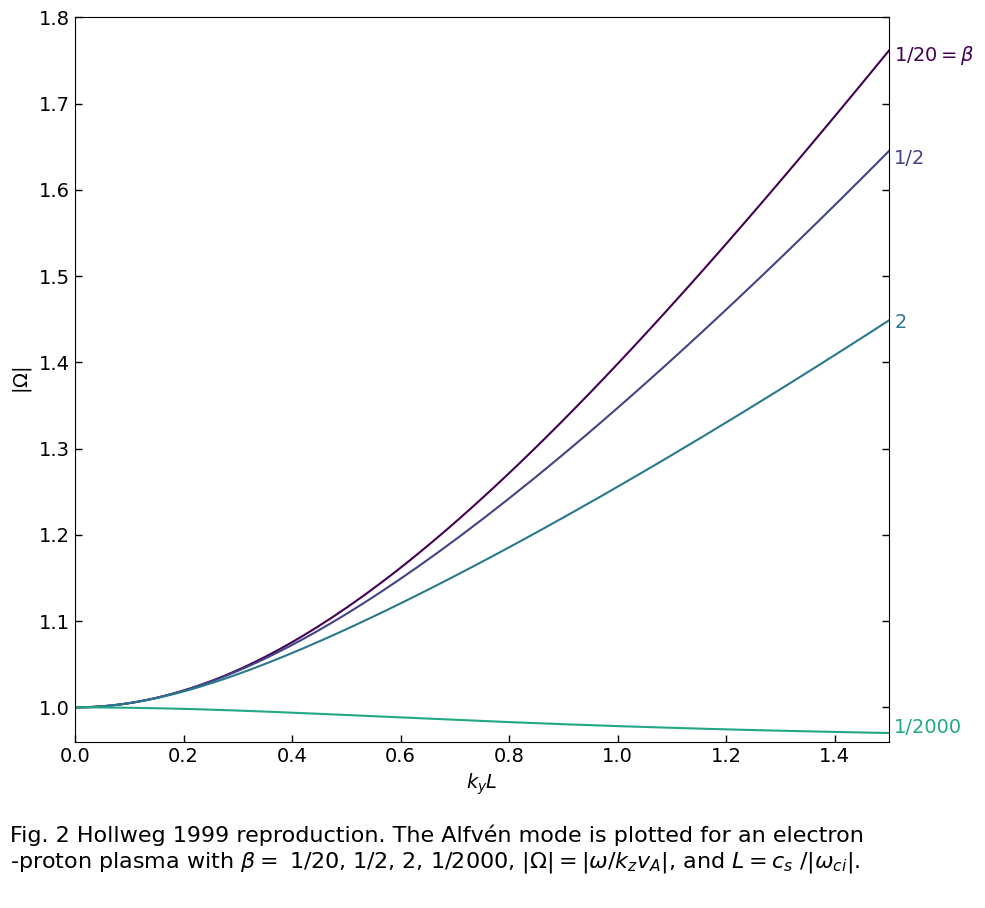

In [27]:
fs = 14  # default font size
figwidth, figheight = plt.rcParams["figure.figsize"]
figheight = 1.6 * figheight
fig = plt.figure(figsize=[figwidth, figheight])

# define colormap
cmap = plt.get_cmap("viridis")
slicedCM = cmap(np.linspace(0, 0.6, 4))

# plot
plt.plot(
    k_prime[0],
    big_omega[0],
    c=slicedCM[0],
    ms=1,
)
ax = plt.gca()
ax.plot(
    k_prime[1],
    big_omega[1],
    c=slicedCM[1],
    ms=1,
)
ax.plot(
    k_prime[2],
    big_omega[2],
    c=slicedCM[2],
    ms=1,
)
ax.plot(
    k_prime[3],
    big_omega[3],
    c=slicedCM[3],
    ms=1,
)

# adjust axes
ax.set_xlabel(r"$k_{y}L$", fontsize=fs)
ax.set_ylabel(r"$|\Omega|$", fontsize=fs)
ax.set_yscale("linear")
ax.set_xscale("linear")
ax.set_xlim(0, 1.5)
ax.set_ylim(0.96, 1.8)
ax.tick_params(
    which="both",
    direction="in",
    width=1,
    labelsize=fs,
    right=True,
    length=5,
)

# add labels for beta
plt.text(1.51, 1.75, "1/20$=\\beta$", c=slicedCM[0], fontsize=fs)
plt.text(1.51, 1.63, "1/2", c=slicedCM[1], fontsize=fs)
plt.text(1.51, 1.44, "2", c=slicedCM[2], fontsize=fs)
plt.text(1.51, 0.97, "1/2000", c=slicedCM[3], fontsize=fs)

# plot caption
txt = (
    "Fig. 2 Hollweg 1999 reproduction. The Alfvén mode is plotted for an electron\n"
    "-proton plasma with $\\beta=$ 1/20, 1/2, 2, 1/2000, $|\\Omega|=|\\omega / k_{z} v_{A}|$, and $L=c_{s}$ $/ |\\omega_{ci}|$.\n"
)

plt.figtext(-0.08, -0.21, txt, ha="left", transform=ax.transAxes, fontsize=16);

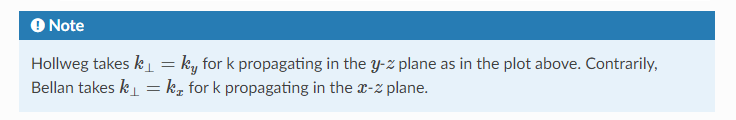